In [2]:
#Importing required packages.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
#from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from imblearn.under_sampling import RandomUnderSampler
%matplotlib inline

Questo è l'inizio del notebook sul classificatore EnIA che predice in base ai dati meteo e del terreno, se è neccesario o no irrigare un terreno agricolo.
La variabile categorica da predire sarà irrigation, che potrà assumere 4 valori diversi: [No, Bassa, Media, Alta] che indica il livello di acqua che l'irrigatore dovrà distribuire

Importing Data and Data Preparation

In [3]:
#load training data
irrigazione = pd.read_csv('Dataset\DatasetEnIA.csv')
#round the decimal data to 2 decimal places
irrigazione = irrigazione.round(2)
#drop weathercode (wmo code) column
irrigazione = irrigazione.drop(columns=['weathercode (wmo code)'])

In [4]:
#drop weathercode (wmo code)
irrigazione.transpose()

,0,1,2,3,4,5,6,7,8,9,...,4739,4740,4741,4742,4743,4744,4745,4746,4747,4748
time,2010-01-01,2010-01-02,2010-01-03,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-09,2010-01-10,...,2022-12-23,2022-12-24,2022-12-25,2022-12-26,2022-12-27,2022-12-28,2022-12-29,2022-12-30,2022-12-31,2023-01-01
surface_pressure (hPa),983.0,990.18,1001.91,1000.48,988.98,987.31,993.74,986.75,986.74,994.92,...,1002.05,1003.45,1008.94,1012.95,1012.21,1011.15,1010.72,1010.27,1014.62,1015.97
soil_moisture_0_to_7cm (m³/m³),0.43,0.41,0.39,0.4,0.42,0.42,0.41,0.42,0.42,0.43,...,0.36,0.36,0.36,0.36,0.35,0.35,0.35,0.35,0.35,0.35
et0_fao_evapotranspiration (mm),0.98,1.54,1.48,0.59,0.65,0.8,1.04,0.49,0.68,0.84,...,0.79,0.62,0.73,0.66,0.88,0.88,0.96,0.82,0.97,1.03
rain (mm),37.9,5.1,0.0,11.3,7.7,23.9,7.9,31.3,28.5,10.0,...,0.1,0.3,0.0,0.0,0.0,0.0,0.8,0.9,0.0,0.0
windspeed_10m (km/h),25.43,21.95,11.36,9.02,8.98,16.11,10.23,14.38,15.85,9.55,...,3.73,3.49,3.21,3.67,3.4,3.73,5.59,6.42,3.22,3.11
relativehumidity_2m (%),83.54,76.42,59.25,77.58,87.79,86.71,83.75,86.71,84.62,81.38,...,91.12,93.17,90.17,90.46,88.96,89.29,87.38,87.04,87.88,92.38
temperature_2m (°C),11.3,10.77,7.72,7.63,12.6,11.79,11.41,12.23,9.33,7.61,...,12.06,13.22,13.5,12.91,13.06,12.78,12.42,12.91,13.2,12.37
soil_temperature_0_to_7cm (°C),12.21,11.5,10.01,8.84,11.65,12.04,11.95,11.95,10.56,9.14,...,11.99,12.74,13.22,12.9,12.73,12.5,12.33,12.48,12.32,11.52
cloudcover (%),76.67,50.12,39.58,97.54,91.21,81.67,54.71,86.62,77.08,74.25,...,48.5,90.75,51.58,82.54,76.12,47.42,54.54,68.38,26.62,21.88


Eliminiamo la colonna Time, non ci serve

In [5]:
irrigazione = irrigazione.drop(['time'], axis=1)

Convertiamo crop e stageOfGrowth alla loro rappresentazione numerica usando gli array

In [6]:
CropType = ["Barley", "Bean", "Cabbage", "Carrot", "Cotton", "Cucumber", "Eggplant", "Grain", "Lentil", "Lettuce"]
GrowthType = ["InitialStage", "CropDevStage", "MidSeasonStage", "LateSeasonStage"]

irrigazione["crop"] = irrigazione["crop"].apply(lambda x: CropType.index(x))
irrigazione['stageOfGrowth'] = irrigazione['stageOfGrowth'].apply(lambda x: GrowthType.index(x))

In [7]:
irrigazione

,surface_pressure (hPa),soil_moisture_0_to_7cm (m³/m³),et0_fao_evapotranspiration (mm),rain (mm),windspeed_10m (km/h),relativehumidity_2m (%),temperature_2m (°C),soil_temperature_0_to_7cm (°C),cloudcover (%),shortwave_radiation (W/m²),crop,stageOfGrowth,Kc,irrigation
0,983.00,0.43,0.98,37.9,25.43,83.54,11.30,12.21,76.67,1144.0,3,3,0.90,0
1,990.18,0.41,1.54,5.1,21.95,76.42,10.77,11.50,50.12,1792.0,4,2,1.15,0
2,1001.91,0.39,1.48,0.0,11.36,59.25,7.72,10.01,39.58,1931.0,9,2,1.00,1
3,1000.48,0.40,0.59,11.3,9.02,77.58,7.63,8.84,97.54,739.0,4,1,0.75,0
4,988.98,0.42,0.65,7.7,8.98,87.79,12.60,11.65,91.21,1105.0,5,1,0.70,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4744,1011.15,0.35,0.88,0.0,3.73,89.29,12.78,12.50,47.42,1624.0,2,0,0.45,1
4745,1010.72,0.35,0.96,0.8,5.59,87.38,12.42,12.33,54.54,1692.0,1,2,1.10,1
4746,1010.27,0.35,0.82,0.9,6.42,87.04,12.91,12.48,68.38,1280.0,1,0,0.35,1
4747,1014.62,0.35,0.97,0.0,3.22,87.88,13.20,12.32,26.62,1823.0,1,0,0.35,1


In [8]:
#Caratteristiche del nostro dataset
irrigazione.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
surface_pressure (hPa),4749.0,1000.576045,6.375738,972.91,997.24,1000.56,1004.15,1021.68
soil_moisture_0_to_7cm (m³/m³),4749.0,0.298705,0.094043,0.13,0.22,0.33,0.38,0.43
et0_fao_evapotranspiration (mm),4749.0,2.842723,1.572488,0.33,1.39,2.62,4.22,6.79
rain (mm),4749.0,3.292104,7.795533,0.00,0.00,0.00,2.20,79.70
windspeed_10m (km/h),4749.0,8.210164,4.030778,2.55,5.54,6.85,9.64,33.39
relativehumidity_2m (%),4749.0,76.026254,9.139055,42.75,70.67,77.29,82.83,95.04
temperature_2m (°C),4749.0,16.292331,6.134794,-0.80,11.17,15.55,21.73,29.08
soil_temperature_0_to_7cm (°C),4749.0,17.258577,6.685841,1.57,11.58,16.35,23.30,31.15
cloudcover (%),4749.0,36.063973,27.555232,0.00,12.04,30.54,56.62,100.00
shortwave_radiation (W/m²),4749.0,4350.670457,2134.954262,203.00,2342.00,4334.00,6297.00,8179.00


Data Cleaning

Non ci sono ne dati duplicati ne dati null

In [9]:
irrigazione.isnull().sum()

surface_pressure (hPa)             0
soil_moisture_0_to_7cm (m³/m³)     0
et0_fao_evapotranspiration (mm)    0
rain (mm)                          0
windspeed_10m (km/h)               0
relativehumidity_2m (%)            0
temperature_2m (°C)                0
soil_temperature_0_to_7cm (°C)     0
cloudcover (%)                     0
shortwave_radiation (W/m²)         0
crop                               0
stageOfGrowth                      0
Kc                                 0
irrigation                         0
dtype: int64

In [10]:
irrigazione.duplicated().sum()

0

Bilanciamento Dati

Si utilizzeranno due diverse tecniche di sampling, SMOTE e RANDOM UNDER SAMPLER.

<Axes: xlabel='irrigation', ylabel='count'>

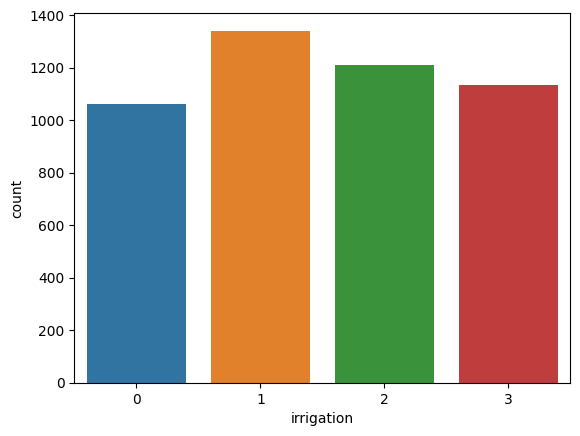

In [11]:
#La variabile categorica ha questi valori
sns.countplot(x='irrigation', data=irrigazione)

In [12]:
#undersample the dataset based on irrigation
rus = RandomUnderSampler(random_state=42)
X = irrigazione.drop('irrigation', axis=1)
y = irrigazione['irrigation']
X_res, y_res = rus.fit_resample(X, y)
#concatenate the undersampled dataset
irrigazione_under = pd.concat([X_res, y_res], axis=1)

In [13]:
irrigazione_under

,surface_pressure (hPa),soil_moisture_0_to_7cm (m³/m³),et0_fao_evapotranspiration (mm),rain (mm),windspeed_10m (km/h),relativehumidity_2m (%),temperature_2m (°C),soil_temperature_0_to_7cm (°C),cloudcover (%),shortwave_radiation (W/m²),crop,stageOfGrowth,Kc,irrigation
0,983.00,0.43,0.98,37.9,25.43,83.54,11.30,12.21,76.67,1144.0,3,3,0.90,0
1,990.18,0.41,1.54,5.1,21.95,76.42,10.77,11.50,50.12,1792.0,4,2,1.15,0
2,1000.48,0.40,0.59,11.3,9.02,77.58,7.63,8.84,97.54,739.0,4,1,0.75,0
3,988.98,0.42,0.65,7.7,8.98,87.79,12.60,11.65,91.21,1105.0,5,1,0.70,0
4,987.31,0.42,0.80,23.9,16.11,86.71,11.79,12.04,81.67,1379.0,5,0,0.45,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4243,1001.95,0.25,4.87,0.0,4.50,81.50,19.58,19.77,5.96,7600.0,3,1,0.75,3
4244,1000.76,0.28,3.48,0.0,8.51,67.25,13.61,15.76,37.25,6009.0,2,2,1.05,3
4245,1003.16,0.30,4.68,0.0,4.03,84.67,21.88,22.31,22.54,7073.0,1,3,0.90,3
4246,998.22,0.13,4.85,0.5,4.62,78.62,26.72,29.00,11.54,6644.0,5,3,0.75,3


In [14]:
#oversample the dataset using SMOTE
sm = SMOTE(random_state=42)
X = irrigazione.drop('irrigation', axis=1)
y = irrigazione['irrigation']
X_res, y_res = sm.fit_resample(X, y)
#concatenate the oversampled dataset
irrigazione_smote = pd.concat([X_res, y_res], axis=1)

In [15]:
irrigazione_smote

,surface_pressure (hPa),soil_moisture_0_to_7cm (m³/m³),et0_fao_evapotranspiration (mm),rain (mm),windspeed_10m (km/h),relativehumidity_2m (%),temperature_2m (°C),soil_temperature_0_to_7cm (°C),cloudcover (%),shortwave_radiation (W/m²),crop,stageOfGrowth,Kc,irrigation
0,983.000000,0.430000,0.980000,37.90000,25.430000,83.540000,11.300000,12.210000,76.670000,1144.000000,3,3,0.900000,0
1,990.180000,0.410000,1.540000,5.10000,21.950000,76.420000,10.770000,11.500000,50.120000,1792.000000,4,2,1.150000,0
2,1001.910000,0.390000,1.480000,0.00000,11.360000,59.250000,7.720000,10.010000,39.580000,1931.000000,9,2,1.000000,1
3,1000.480000,0.400000,0.590000,11.30000,9.020000,77.580000,7.630000,8.840000,97.540000,739.000000,4,1,0.750000,0
4,988.980000,0.420000,0.650000,7.70000,8.980000,87.790000,12.600000,11.650000,91.210000,1105.000000,5,1,0.700000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5359,993.320102,0.265697,4.511332,0.32121,8.381173,79.143894,19.660045,21.500650,14.287090,7241.496935,3,1,0.924847,3
5360,1002.395959,0.192121,5.177805,0.00000,4.926405,65.333046,23.163234,22.914973,36.210263,7248.132557,1,3,0.900000,3
5361,997.206823,0.279707,3.954353,0.33138,8.162251,80.805722,18.480472,20.185243,20.722934,6539.615083,6,2,0.982845,3
5362,1002.403447,0.227770,4.225012,0.00000,5.556620,75.802110,21.071451,22.775106,29.091240,6250.358619,5,2,0.758965,3


<Axes: xlabel='irrigation', ylabel='count'>

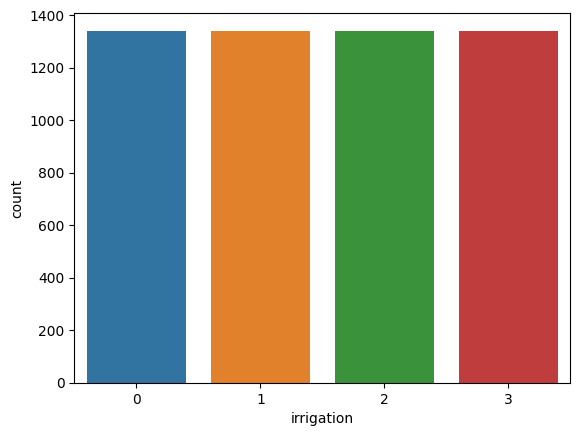

In [16]:
#La variabile categorica ha questi valori
sns.countplot(x='irrigation', data=irrigazione_smote)

Split Test and Train Data per i dati che verranno utilizzato dall'algoritmo genetico

In [17]:
irrigazione_X = irrigazione.drop('irrigation', axis=1)
irrigazione_y = irrigazione['irrigation']
irrigazione_X_smote = irrigazione_smote.drop('irrigation', axis=1)
irrigazione_y_smote = irrigazione_smote['irrigation']

In [18]:
#Applichiamo una normalizzazione ai dati
from sklearn.preprocessing import MinMaxScaler


normalizer = MinMaxScaler()
normalizer_smote = MinMaxScaler()
normalizer_under = MinMaxScaler()

transformer = normalizer.fit(irrigazione_X)
transformer_smote = normalizer_smote.fit(irrigazione_X_smote)
transformer_under = normalizer_under.fit(irrigazione_under.drop('irrigation', axis=1))

irrigazione_smote_X_normalized = transformer_smote.transform(irrigazione_X_smote)
irrigazione_X_normalized = transformer.transform(irrigazione_X)
irrigazione_X_under_normalized = transformer_under.transform(irrigazione_under.drop('irrigation', axis=1))

irr_X_train, irr_X_test, irr_y_train, irr_y_test = train_test_split(irrigazione_X_normalized, irrigazione_y, test_size=0.2, random_state=42)
irr_X_train_smote, irr_X_test_smote, irr_y_train_smote, irr_y_test_smote = train_test_split(irrigazione_smote_X_normalized, irrigazione_y_smote, test_size=0.2, random_state=42)
irr_X_train_under, irr_X_test_under, irr_y_train_under, irr_y_test_under = train_test_split(irrigazione_X_under_normalized, irrigazione_under['irrigation'], test_size=0.2, random_state=42)

In [19]:
pd.DataFrame(irrigazione_X_normalized)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.206889,1.000000,0.100619,0.475533,0.741894,0.780073,0.404953,0.359703,0.7667,0.117979,0.333333,1.000000,0.423077
1,0.354111,0.933333,0.187307,0.063990,0.629053,0.643909,0.387216,0.335700,0.5012,0.199223,0.444444,0.666667,0.615385
2,0.594628,0.866667,0.178019,0.000000,0.285668,0.315548,0.285141,0.285328,0.3958,0.216650,1.000000,0.666667,0.500000
3,0.565307,0.900000,0.040248,0.141782,0.209792,0.666093,0.282129,0.245774,0.9754,0.067202,0.444444,0.333333,0.307692
4,0.329506,0.966667,0.049536,0.096612,0.208495,0.861350,0.448461,0.340771,0.9121,0.113089,0.555556,0.333333,0.269231
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4744,0.784089,0.733333,0.085139,0.000000,0.038262,0.890036,0.454485,0.369506,0.4742,0.178159,0.222222,0.000000,0.076923
4745,0.775272,0.733333,0.097523,0.010038,0.098573,0.853509,0.442436,0.363759,0.5454,0.186685,0.111111,0.666667,0.576923
4746,0.766045,0.733333,0.075851,0.011292,0.125486,0.847007,0.458835,0.368830,0.6838,0.135030,0.111111,0.000000,0.000000
4747,0.855239,0.733333,0.099071,0.000000,0.021725,0.863071,0.468541,0.363421,0.2662,0.203109,0.111111,0.000000,0.000000


FEATURE SELECTION CON ALGORITMO GENETICO

In [20]:
from geneticalgorithm2 import geneticalgorithm2 as ga
from geneticalgorithm2 import Crossover
from geneticalgorithm2 import Mutations
from geneticalgorithm2 import Selection
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.metrics import f1_score

dataset_X_train = irr_X_train_smote
dataset_y_train = irr_y_train_smote
dataset_X_test = irr_X_test_smote
dataset_y_test = irr_y_test_smote

#implement bit flip mutation
def bit_flip_mutation(current_value: int, left_border: int, right_border: int) -> int:
    return (1 + current_value) % 2

size_popolazione = 20
crossover_probability = 0.2
popolazione = {}
mutation_prob = 0.1

""" 
    max_depth: vale massimo 20
    min_samples_split: tra 2 e 500
    min_sample_leaf: tra 1 e 1000
    max_features: tra 1 e 9
"""
var_types = np.array(["int","int","int","int", "int","int","int","int","int","int","int","int","int"])
#inizializza un array con 13 [0,1]
vincoli = np.array([[0, 1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1]])

alg_param = {
            'max_num_iteration': 100,
            'population_size': size_popolazione,
            'mutation_probability': mutation_prob,
            'elit_ratio': 0.2,
            'parents_portion' : 0.2,
            'crossover_type': Crossover.two_point(),
            'mutation_type': bit_flip_mutation,
            'selection_type': Selection.tournament(),    #DA VEDERE IL PARAMETRO
            'max_iteration_without_improv': 30
}



#f-measure
#fitness in questa libreria è una funzione di minimo perciò restituiamo -result.
def fitness_gaussian(param):
    #se param ha tutti 0 allora non esegue il fit
    if np.sum(param) == 0:
        return 0
    #elimina le feature in base all'array param che è del tipo [0,1,0,1,0,1,0,1,0,1,0,1,0]
    irr_X_train_buff = np.delete(dataset_X_train, np.where(param == 0), axis=1)
    irr_X_test_buff = np.delete(dataset_X_test, np.where(param == 0), axis=1)
    
    
    tree = GaussianNB()
    #490 è il 70% di 700
    tree.fit(irr_X_train_buff, dataset_y_train)
    prediction = tree.predict(irr_X_test_buff)
    result = f1_score(dataset_y_test, prediction, average='weighted')
    return -result

def fitness_decision_tree(param):
    #se param ha tutti 0 allora non esegue il fit
    if np.sum(param) == 0:
        return 0
    #elimina le feature in base all'array param che è del tipo [0,1,0,1,0,1,0,1,0,1,0,1,0]
    irr_X_train_buff = np.delete(dataset_X_train, np.where(param == 0), axis=1)
    irr_X_test_buff = np.delete(dataset_X_test, np.where(param == 0), axis=1)
    
    
    tree = DecisionTreeClassifier()
    #490 è il 70% di 700
    tree.fit(irr_X_train_buff, dataset_y_train)
    prediction = tree.predict(irr_X_test_buff)
    result = f1_score(dataset_y_test, prediction, average='weighted')
    return -result

    
def get_best_solution(genetico) -> np.ndarray:
    result = genetico.result.last_generation.variables
    scores = genetico.result.last_generation.scores
    #get the best score index
    best_score_index = np.argmin(scores)
    #get best solution
    best_solution = result[best_score_index]
    #convert the solution to the feature names
    best_solution = np.delete(irrigazione_X.columns, np.where(best_solution == 0))
    return best_solution

Estraiamo tramite un algoritmo genetico le feature più importanti nel caso del decision tree


Set: Average time of function evaluating (secs): 0.04926986694335937 (total = 0.9853973388671875)

Best score before optimization: -0.9803876063571407
                                                                                                                                                                                                        
 The best found solution:
 [1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1.]

 Objective function:
 -0.9841337093404694

 Used generations: 39
 Used time: 20.5 seconds


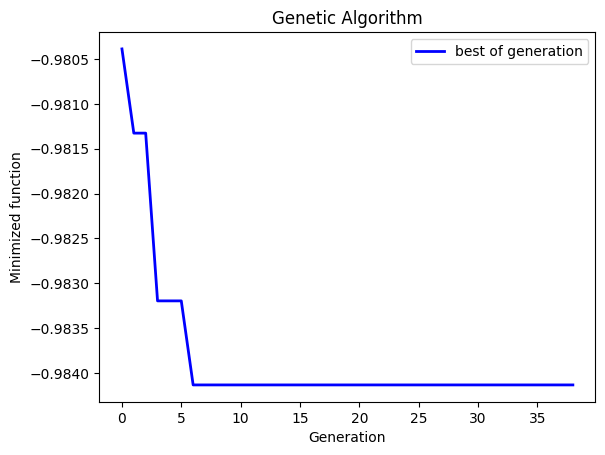


       'rain (mm)', 'temperature_2m (°C)', 'soil_temperature_0_to_7cm (°C)',
       'Kc'],
      dtype='object')


In [21]:
genetico = ga(function=fitness_decision_tree, dimension=13, variable_type="int", variable_boundaries=vincoli, algorithm_parameters=alg_param)
#run the genetic algorithm 10 times and get the best solution, assign a thread to each run
genetico.run()
best_solution_decision_tree = get_best_solution(genetico)
print("Best solution: ", get_best_solution(genetico))

Le feature più importanti estratte dall'algoritmo genetico sono 'et0_fao_evapotranspiration (mm)', 'rain (mm)', 'temperature_2m (°C)', 'Kc'

Estraiamo tramite un algoritmo genetico le feature più importanti nel caso del gaussian naive bayes


Set: Average time of function evaluating (secs): 0.007779216766357422 (total = 0.15558433532714844)

Best score before optimization: -0.8089254801426392
                                                                                                                                                                                                        
 The best found solution:
 [0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1.]

 Objective function:
 -0.8588658743082991

 Used generations: 41
 Used time: 4.64 seconds


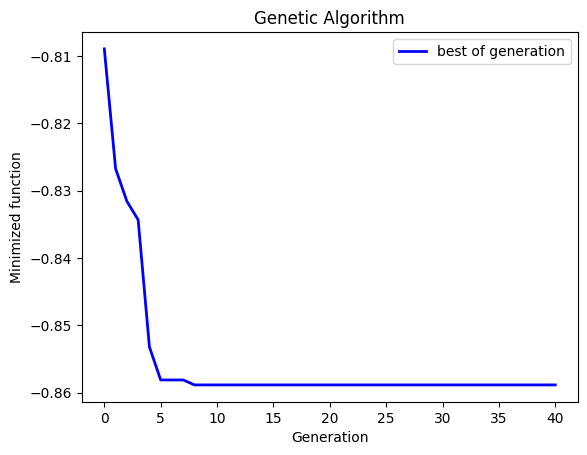


       'shortwave_radiation (W/m²)', 'stageOfGrowth', 'Kc'],
      dtype='object')


In [22]:
genetico = ga(function=fitness_gaussian, dimension=13, variable_type="int", variable_boundaries=vincoli, algorithm_parameters=alg_param)
genetico.run()
best_solution_gaussian = get_best_solution(genetico)
print(get_best_solution(genetico))

Le feature più importanti estratte dall'algoritmo genetico sono 'et0_fao_evapotranspiration (mm)', 'rain (mm)', 'stageOfGrowth', 'Kc'

Non verrà applicato l'algoritmo genetico al random forest dato che è un insieme di alberi decisionali, si useranno quindi le feature selezionate per l'algoritmo decision tree

In [23]:
irrigazione_X

,surface_pressure (hPa),soil_moisture_0_to_7cm (m³/m³),et0_fao_evapotranspiration (mm),rain (mm),windspeed_10m (km/h),relativehumidity_2m (%),temperature_2m (°C),soil_temperature_0_to_7cm (°C),cloudcover (%),shortwave_radiation (W/m²),crop,stageOfGrowth,Kc
0,983.00,0.43,0.98,37.9,25.43,83.54,11.30,12.21,76.67,1144.0,3,3,0.90
1,990.18,0.41,1.54,5.1,21.95,76.42,10.77,11.50,50.12,1792.0,4,2,1.15
2,1001.91,0.39,1.48,0.0,11.36,59.25,7.72,10.01,39.58,1931.0,9,2,1.00
3,1000.48,0.40,0.59,11.3,9.02,77.58,7.63,8.84,97.54,739.0,4,1,0.75
4,988.98,0.42,0.65,7.7,8.98,87.79,12.60,11.65,91.21,1105.0,5,1,0.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4744,1011.15,0.35,0.88,0.0,3.73,89.29,12.78,12.50,47.42,1624.0,2,0,0.45
4745,1010.72,0.35,0.96,0.8,5.59,87.38,12.42,12.33,54.54,1692.0,1,2,1.10
4746,1010.27,0.35,0.82,0.9,6.42,87.04,12.91,12.48,68.38,1280.0,1,0,0.35
4747,1014.62,0.35,0.97,0.0,3.22,87.88,13.20,12.32,26.62,1823.0,1,0,0.35


DECISION TREE

Si normalizzano i dataset e si fa lo split dei dati di training e di test


In [24]:
from sklearn.preprocessing import MinMaxScaler

#usa le feature selezionate dalla ricerca genetica
irrigazione_X_dt = irrigazione_X[best_solution_decision_tree]
irrigazione_X_smote_dt = irrigazione_X_smote[best_solution_decision_tree]
irrigazione_X_under_dt = irrigazione_under[best_solution_decision_tree]

#Inizializza i min max scaler per normalizzare i dati su ogni dataset
normalizer = MinMaxScaler()
normalizer_smote = MinMaxScaler()
normalizer_under = MinMaxScaler()

#addestra il min max scaler sui dataset
transformer = normalizer.fit(irrigazione_X_dt)
transformer_smote = normalizer_smote.fit(irrigazione_X_smote_dt)
transformer_under = normalizer_under.fit(irrigazione_X_under_dt)

#infine applica la normalizzazione sui dataset
irrigazione_smote_X_normalized = transformer_smote.transform(irrigazione_X_smote_dt)
irrigazione_X_normalized = transformer.transform(irrigazione_X_dt)
irrigazione_X_under_normalized = transformer_under.transform(irrigazione_X_under_dt)

#splitta i dataset in train e test
irr_X_train, irr_X_test, irr_y_train, irr_y_test = train_test_split(irrigazione_X_normalized, irrigazione_y, test_size=0.2)
irr_X_train_smote, irr_X_test_smote, irr_y_train_smote, irr_y_test_smote = train_test_split(irrigazione_smote_X_normalized, irrigazione_y_smote, test_size=0.2)
irr_X_train_under, irr_X_test_under, irr_y_train_under, irr_y_test_under = train_test_split(irrigazione_X_under_normalized, irrigazione_under['irrigation'], test_size=0.2)

In [25]:
irrigazione_X_dt

,surface_pressure (hPa),et0_fao_evapotranspiration (mm),rain (mm),temperature_2m (°C),soil_temperature_0_to_7cm (°C),Kc
0,983.00,0.98,37.9,11.30,12.21,0.90
1,990.18,1.54,5.1,10.77,11.50,1.15
2,1001.91,1.48,0.0,7.72,10.01,1.00
3,1000.48,0.59,11.3,7.63,8.84,0.75
4,988.98,0.65,7.7,12.60,11.65,0.70
...,...,...,...,...,...,...
4744,1011.15,0.88,0.0,12.78,12.50,0.45
4745,1010.72,0.96,0.8,12.42,12.33,1.10
4746,1010.27,0.82,0.9,12.91,12.48,0.35
4747,1014.62,0.97,0.0,13.20,12.32,0.35


In [26]:
tree_clf = DecisionTreeClassifier()

tree_clf.fit(irr_X_train, irr_y_train)
pred_clf = tree_clf.predict(irr_X_test)
print(classification_report(irr_y_test, pred_clf))
tree_clf_smote = DecisionTreeClassifier()
tree_clf_smote.fit(irr_X_train_smote, irr_y_train_smote)
pred_clf_smote = tree_clf_smote.predict(irr_X_test_smote)
print(classification_report(irr_y_test_smote, pred_clf_smote))
tree_clf_under = DecisionTreeClassifier()
tree_clf_under.fit(irr_X_train_under, irr_y_train_under)
pred_clf_under = tree_clf_under.predict(irr_X_test_under)
print(classification_report(irr_y_test_under, pred_clf_under))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       211
           1       0.94      0.96      0.95       253
           2       0.95      0.97      0.96       246
           3       1.00      0.97      0.98       240

    accuracy                           0.96       950
   macro avg       0.97      0.96      0.96       950
weighted avg       0.96      0.96      0.96       950

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       253
           1       0.96      0.96      0.96       285
           2       0.97      0.96      0.96       288
           3       0.98      0.99      0.98       247

    accuracy                           0.97      1073
   macro avg       0.97      0.97      0.97      1073
weighted avg       0.97      0.97      0.97      1073

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       201
           1       0.

In [27]:
#import cross_validate
from sklearn.model_selection import cross_validate
#import KFold
from sklearn.model_selection import KFold
#import precision_score
from sklearn.metrics import precision_score
#import StratifiedKFold
from sklearn.model_selection import StratifiedKFold

nb_clf_kfold = DecisionTreeClassifier()
#stratified k-fold with shuffle
k_folds = KFold(n_splits=5, shuffle=True)
#scoring metrics
scoring = ['precision_macro', 'recall_macro', 'f1_macro', 'accuracy']

scores = cross_validate(nb_clf_kfold, irrigazione_X_normalized, irrigazione_y, cv=k_folds, scoring=scoring)
scores_under = cross_validate(nb_clf_kfold, irrigazione_X_under_normalized, irrigazione_under['irrigation'], cv=k_folds, scoring=scoring)
scores_smote = cross_validate(nb_clf_kfold, irrigazione_smote_X_normalized, irrigazione_y_smote, cv=k_folds, scoring=scoring)

scores_recall = cross_validate(nb_clf_kfold, irrigazione_X_normalized, irrigazione_y, cv=k_folds, scoring='recall_macro')
scores_under_recall = cross_validate(nb_clf_kfold, irrigazione_X_under_normalized, irrigazione_under['irrigation'], cv=k_folds, scoring='recall_macro')
scores_smote_recall = cross_validate(nb_clf_kfold, irrigazione_smote_X_normalized, irrigazione_y_smote, cv=k_folds, scoring='recall_macro')

#print average accuracy score
print("prova")
print("----------UNTOUCHED SCORES--------")
print("average precision:   " + str(scores.get('test_precision_macro').mean()))
print("average recall:  " + str(scores.get('test_recall_macro').mean()))
print("average f1-score:    " + str(scores.get('test_f1_macro').mean()))
print("average accuracy score:  " + str(scores.get('test_accuracy').mean()))

print("-----------RUS SCORES--------")
#print under sampling scores
print("average precision:   " + str(scores_under.get('test_precision_macro').mean()))
print("average recall:  " + str(scores_under.get('test_recall_macro').mean()))
print("average f1-score: " + str(scores_under.get('test_f1_macro').mean()))
print("average accuracy: " + str(scores_under.get('test_accuracy').mean()))

print("--------SMOTE SCORES--------")
#print smote scores
print("average precision:   " + str(scores_smote.get('test_precision_macro').mean()))
print("average recall:  " + str(scores_smote.get('test_recall_macro').mean()))
print("average f1-score: " + str(scores_smote.get('test_f1_macro').mean()))
print("average accuracy:    " + str(scores_smote.get('test_accuracy').mean()))

prova
----------UNTOUCHED SCORES--------
average precision:   0.9705206375760789
average recall:  0.9704666456454184
average f1-score:    0.9703672141945276
average accuracy score:  0.9698894126781653
-----------RUS SCORES--------
average precision:   0.9748539428779204
average recall:  0.9748991394934949
average f1-score: 0.9748492483298413
average accuracy: 0.9748146608466708
--------SMOTE SCORES--------
average precision:   0.9727353907321531
average recall:  0.9727800298320458
average f1-score: 0.9727136492188304
average accuracy:    0.9727810157043303


GAUSSIAN NAIVE BAYES

In [28]:
#Applichiamo una normalizzazione ai dati
from sklearn.preprocessing import MinMaxScaler
#usa le feature selezionate dalla ricerca genetica
irrigazione_X_nb = irrigazione_X[best_solution_gaussian]
irrigazione_X_smote_nb = irrigazione_X_smote[best_solution_gaussian]
irrigazione_X_under_nb = irrigazione_under[best_solution_gaussian]

normalizer = MinMaxScaler()
normalizer_smote = MinMaxScaler()
normalizer_under = MinMaxScaler()

transformer = normalizer.fit(irrigazione_X_nb)
transformer_smote = normalizer_smote.fit(irrigazione_X_smote_nb)
transformer_under = normalizer_under.fit(irrigazione_X_under_nb)

irrigazione_smote_X_normalized = transformer_smote.transform(irrigazione_X_smote_nb)
irrigazione_X_normalized = transformer.transform(irrigazione_X_nb)
irrigazione_X_under_normalized = transformer_under.transform(irrigazione_X_under_nb)

irr_X_train, irr_X_test, irr_y_train, irr_y_test = train_test_split(irrigazione_X_normalized, irrigazione_y, test_size=0.2)
irr_X_train_smote, irr_X_test_smote, irr_y_train_smote, irr_y_test_smote = train_test_split(irrigazione_smote_X_normalized, irrigazione_y_smote, test_size=0.2)
irr_X_train_under, irr_X_test_under, irr_y_train_under, irr_y_test_under = train_test_split(irrigazione_X_under_normalized, irrigazione_under['irrigation'], test_size=0.2)

In [29]:
irrigazione_X_nb

,rain (mm),relativehumidity_2m (%),temperature_2m (°C),shortwave_radiation (W/m²),stageOfGrowth,Kc
0,37.9,83.54,11.30,1144.0,3,0.90
1,5.1,76.42,10.77,1792.0,2,1.15
2,0.0,59.25,7.72,1931.0,2,1.00
3,11.3,77.58,7.63,739.0,1,0.75
4,7.7,87.79,12.60,1105.0,1,0.70
...,...,...,...,...,...,...
4744,0.0,89.29,12.78,1624.0,0,0.45
4745,0.8,87.38,12.42,1692.0,2,1.10
4746,0.9,87.04,12.91,1280.0,0,0.35
4747,0.0,87.88,13.20,1823.0,0,0.35


In [30]:
#import accuracy_score
from sklearn.metrics import accuracy_score
bayes_clf = GaussianNB()
bayes_clf.fit(irr_X_train, irr_y_train)
pred_clf = bayes_clf.predict(irr_X_test)
print(accuracy_score(irr_y_test, pred_clf))
print(classification_report(irr_y_test, pred_clf))
bayes_clf_smote = GaussianNB()
bayes_clf_smote.fit(irr_X_train_smote, irr_y_train_smote)
pred_clf_smote = bayes_clf_smote.predict(irr_X_test_smote)
print(accuracy_score(irr_y_test_smote, pred_clf_smote))
print(classification_report(irr_y_test_smote, pred_clf_smote))
bayes_clf_under = GaussianNB()
bayes_clf_under.fit(irr_X_train_under, irr_y_train_under)
pred_clf_under = bayes_clf_under.predict(irr_X_test_under)
print(accuracy_score(irr_y_test_under, pred_clf_under))
print(classification_report(irr_y_test_under, pred_clf_under))
#print accuracy score


0.8410526315789474
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       224
           1       0.79      0.79      0.79       257
           2       0.71      0.75      0.73       233
           3       0.96      0.86      0.91       236

    accuracy                           0.84       950
   macro avg       0.85      0.84      0.84       950
weighted avg       0.85      0.84      0.84       950

0.8527493010251631
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       275
           1       0.84      0.80      0.82       284
           2       0.72      0.75      0.73       259
           3       0.92      0.88      0.90       255

    accuracy                           0.85      1073
   macro avg       0.85      0.85      0.85      1073
weighted avg       0.85      0.85      0.85      1073

0.8611764705882353
              precision    recall  f1-score   support

           0      

In [31]:
#import cross_validate
from sklearn.model_selection import cross_validate
#import StratifiedKFold
from sklearn.model_selection import StratifiedKFold

nb_clf_kfold = GaussianNB()
#stratified k-fold with shuffle
k_folds = KFold(n_splits=5, shuffle=True)
#get scoring for class 0 ,1,2,3 and average
scoring = ['precision_macro', 'recall_macro', 'f1_macro', 'accuracy']


scores = cross_validate(nb_clf_kfold, irrigazione_X_normalized, irrigazione_y, cv=k_folds, scoring=scoring)
scores_under = cross_validate(nb_clf_kfold, irrigazione_X_under_normalized, irrigazione_under['irrigation'], cv=k_folds, scoring=scoring)
scores_smote = cross_validate(nb_clf_kfold, irrigazione_smote_X_normalized, irrigazione_y_smote, cv=k_folds, scoring=scoring)
#print average accuracy score
print("----------UNTOUCHED SCORES--------")
print("average precision:   " + str(scores.get('test_precision_macro').mean()))
print("average recall:  " + str(scores.get('test_recall_macro').mean()))
print("average f1-score:    " + str(scores.get('test_f1_macro').mean()))
print("average accuracy score:  " + str(scores.get('test_accuracy').mean()))

print("-----------RUS SCORES--------")
#print under sampling scores
print("average precision:   " + str(scores_under.get('test_precision_macro').mean()))
print("average recall:  " + str(scores_under.get('test_recall_macro').mean()))
print("average f1-score: " + str(scores_under.get('test_f1_macro').mean()))
print("average accuracy: " + str(scores_under.get('test_accuracy').mean()))

print("--------SMOTE SCORES--------")
#print smote scores
print("average precision:   " + str(scores_smote.get('test_precision_macro').mean()))
print("average recall:  " + str(scores_smote.get('test_recall_macro').mean()))
print("average f1-score: " + str(scores_smote.get('test_f1_macro').mean()))
print("average accuracy:    " + str(scores_smote.get('test_accuracy').mean()))

----------UNTOUCHED SCORES--------
average precision:   0.8572118700096402
average recall:  0.8571546775976822
average f1-score:    0.8568014586621825
average accuracy score:  0.8521830181354334
-----------RUS SCORES--------
average precision:   0.8608586298593451
average recall:  0.861545993159669
average f1-score: 0.8602119205926773
average accuracy: 0.8608813136562045
--------SMOTE SCORES--------
average precision:   0.8619531329397727
average recall:  0.8621518490909784
average f1-score: 0.8615184317853645
average accuracy:    0.862232755143203


FEATURE SELECTION CON MATRICE DI CORRISPONDENZA ( NON UTILIZZIAMO PIù QUESTO METODO)

Useremo una matrice di corrispondenza per vedere quali degli attributi ci è più conveniente tenere per stimare
la variabile categorica irrigazione

<Axes: >

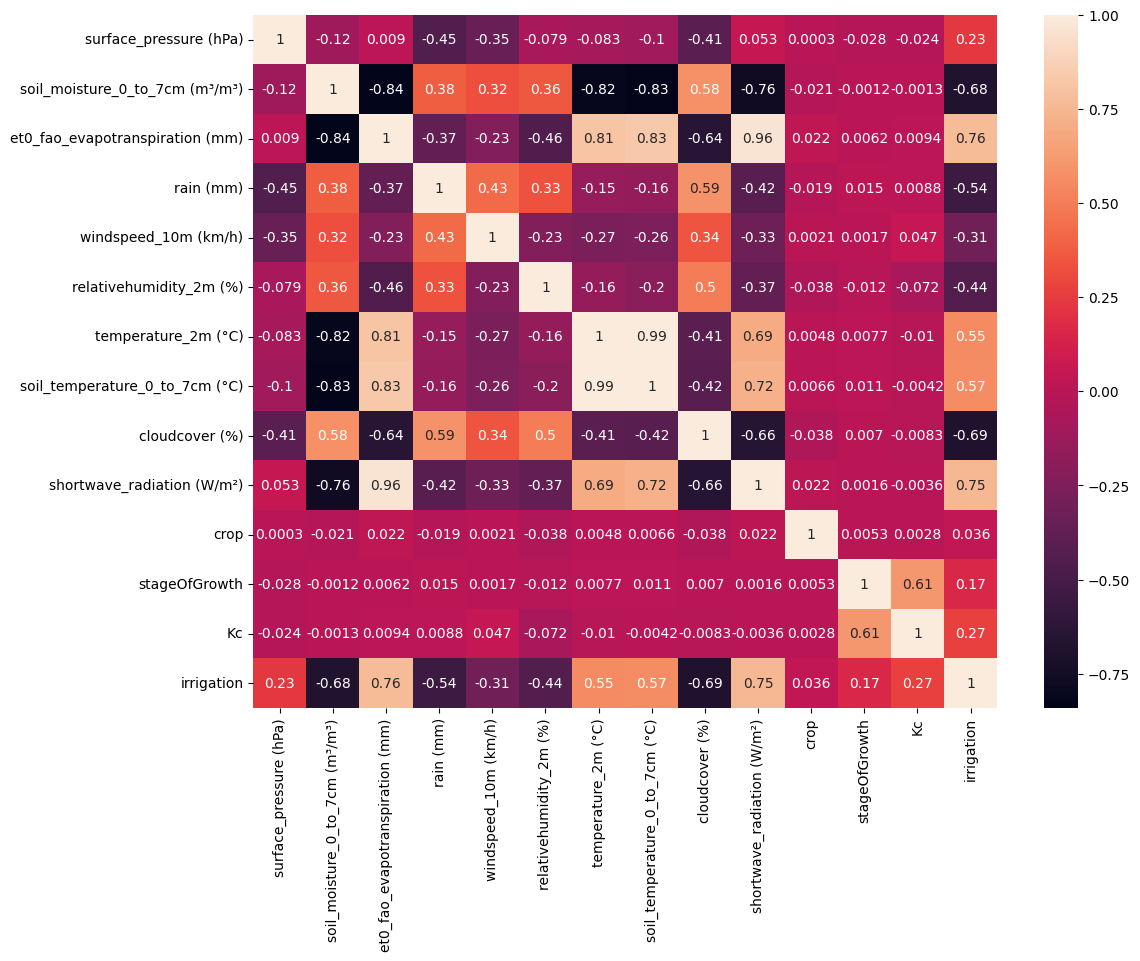

In [32]:
corrmatrix = irrigazione.corr()
#aumentare la dimensione della figura
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmatrix, annot=True)

In [33]:
#crop ha una correlazione di 0.0049 quindi conviene eliminarla
irrigazione = irrigazione.drop("crop", axis=1)
#stage of growth ha una correlazione di 0.17 quindi conviene eliminarla
irrigazione = irrigazione.drop("stageOfGrowth",axis = 1)
#surface_pressure (hPa) ha una correlazione di 0.24 quindi conviene eliminarla
irrigazione = irrigazione.drop("surface_pressure (hPa)", axis = 1)
#Kc ha una correlazione di 0.28, tuttavia è una variabile importante per il nostro modello, dato che indica quanta acqua è in grado di trattenere la coltura, quindi non la eliminiamo

La matrice di corrispondenza ora avrà questo aspetto

prova


<Axes: >

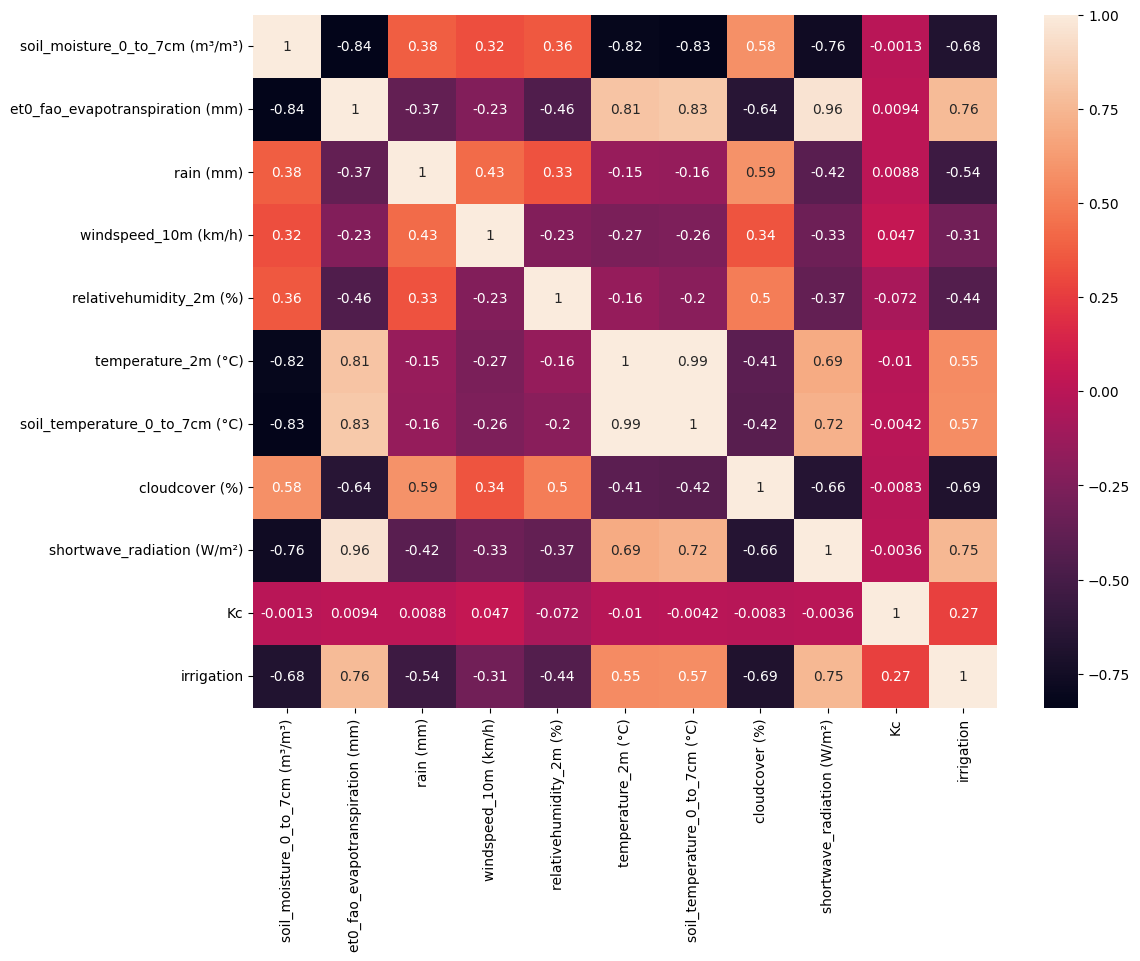

In [34]:
corrmatrix = irrigazione.corr()
print("prova")
#aumentare la dimensione della figura
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmatrix, annot=True)

è convenitente eliminare i dati ridondanti e quelli che hanno una particolare corrispondenza con gli altri, elimineremo gli attributi che hanno un coefficiente di correlazione con altri attributi superiore o uguale a 0.6

In [35]:
#temperature_2m (°C) ha una correlazione di 0.99 con soil_temperature (°C) quindi conviene eliminarla, visto che
#soil_temperature (°C) ha una correlazione più alta con la variabile da predire
irrigazione = irrigazione.drop("temperature_2m (°C)", axis = 1)
#stesso discorso per soil_moisture e evapotranspiration
irrigazione = irrigazione.drop("soil_moisture_0_to_7cm (m³/m³)", axis = 1)
#stesso discorso per temperature_2m (°C) e evapotranspiration
irrigazione = irrigazione.drop("soil_temperature_0_to_7cm (°C)", axis = 1)
#stesso discordo per shortwave_radiation (W/m²) e evapotranspiration
irrigazione = irrigazione.drop("shortwave_radiation (W/m²)", axis = 1)
#stesso discordo per cloud_cover (%) e evapotranspiration
irrigazione = irrigazione.drop("cloudcover (%)", axis = 1)

La matrice di corrispondenza ora avrà questo aspetto

<Axes: >

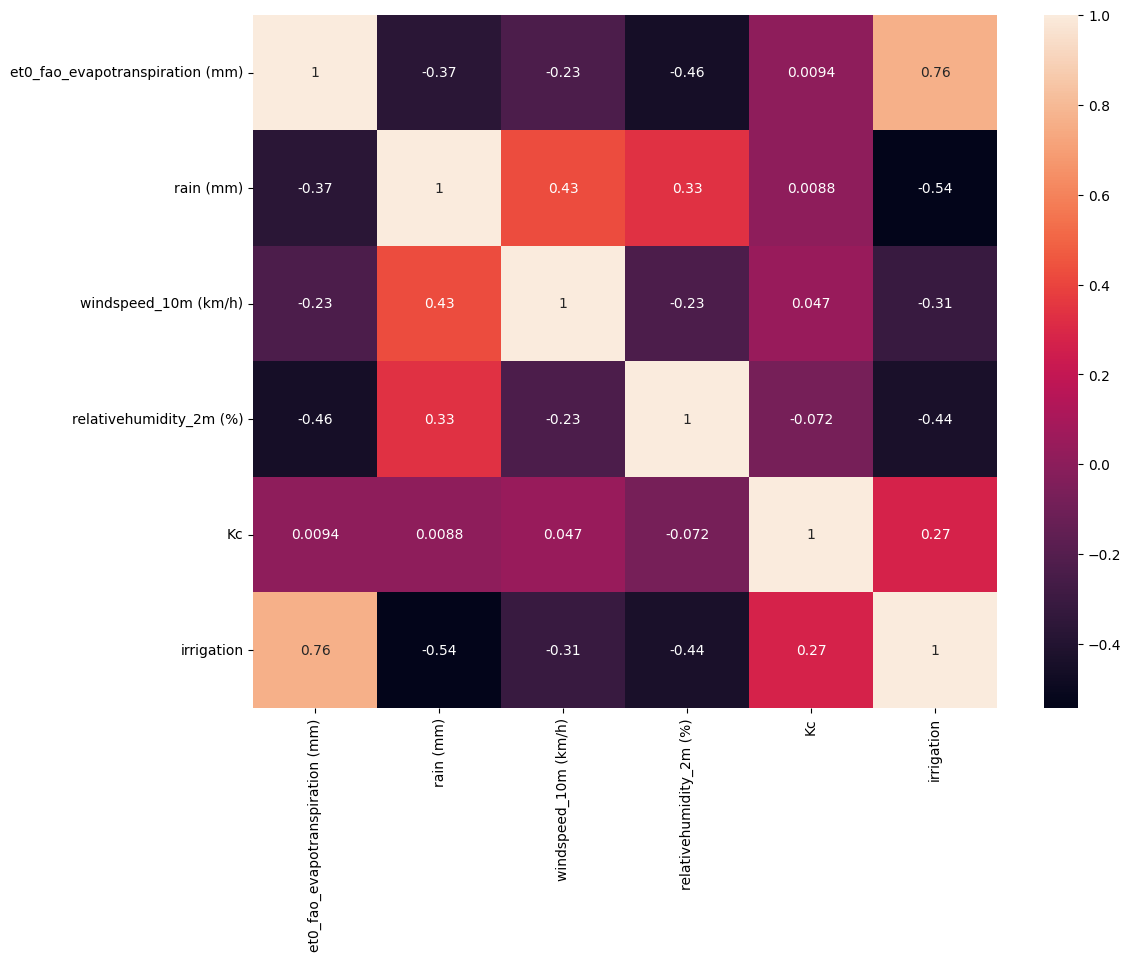

In [36]:
corrmatrix = irrigazione.corr()
#aumentare la dimensione della figura
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmatrix, annot=True)

Split Test and Train Data


In [37]:
irrigazione_X = irrigazione.drop('irrigation', axis=1)
irrigazione_y = irrigazione['irrigation']

In [38]:
#Applichiamo una normalizzazione ai dati
normalizer = StandardScaler()
transformer = normalizer.fit(irrigazione_X)
irrigazione_X_normalized = transformer.transform(irrigazione_X)
irr_X_train, irr_X_test, irr_y_train, irr_y_test = train_test_split(irrigazione_X_normalized, irrigazione_y, test_size=0.2)

In [39]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(irr_X_train, irr_y_train)
pred_clf = tree_clf.predict(irr_X_test)
print(classification_report(irr_y_test, pred_clf))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       222
           1       0.97      0.96      0.96       282
           2       0.96      0.95      0.95       232
           3       0.98      0.99      0.98       214

    accuracy                           0.97       950
   macro avg       0.97      0.97      0.97       950
weighted avg       0.97      0.97      0.97       950



In [40]:
#Numero di foglie dell'albero
print("Il numero di foglie generato dal classificatore è : " + str(tree_clf.get_n_leaves()))

Il numero di foglie generato dal classificatore è : 102


è inoltre interessante visualizzare graficamente l'albero

[Text(0.5750968992248062, 0.9583333333333334, 'rain (mm) <= -0.082\ngini = 0.748\nsamples = 3799\nvalue = [840, 1059, 979, 921]\nclass = Bassa'),
 Text(0.29651162790697677, 0.875, 'et0_fao_evapotranspiration (mm) <= -0.539\ngini = 0.669\nsamples = 2926\nvalue = [14, 1021, 970, 921]\nclass = Bassa'),
 Text(0.1308139534883721, 0.7916666666666666, 'Kc <= 1.094\ngini = 0.218\nsamples = 857\nvalue = [13, 752, 92, 0]\nclass = Bassa'),
 Text(0.08333333333333333, 0.7083333333333334, 'rain (mm) <= -0.147\ngini = 0.097\nsamples = 695\nvalue = [10, 660, 25, 0]\nclass = Bassa'),
 Text(0.04263565891472868, 0.625, 'Kc <= 0.405\ngini = 0.072\nsamples = 669\nvalue = [0, 644, 25, 0]\nclass = Bassa'),
 Text(0.015503875968992248, 0.5416666666666666, 'et0_fao_evapotranspiration (mm) <= -0.59\ngini = 0.007\nsamples = 541\nvalue = [0, 539, 2, 0]\nclass = Bassa'),
 Text(0.007751937984496124, 0.4583333333333333, 'gini = 0.0\nsamples = 518\nvalue = [0, 518, 0, 0]\nclass = Bassa'),
 Text(0.023255813953488372, 0

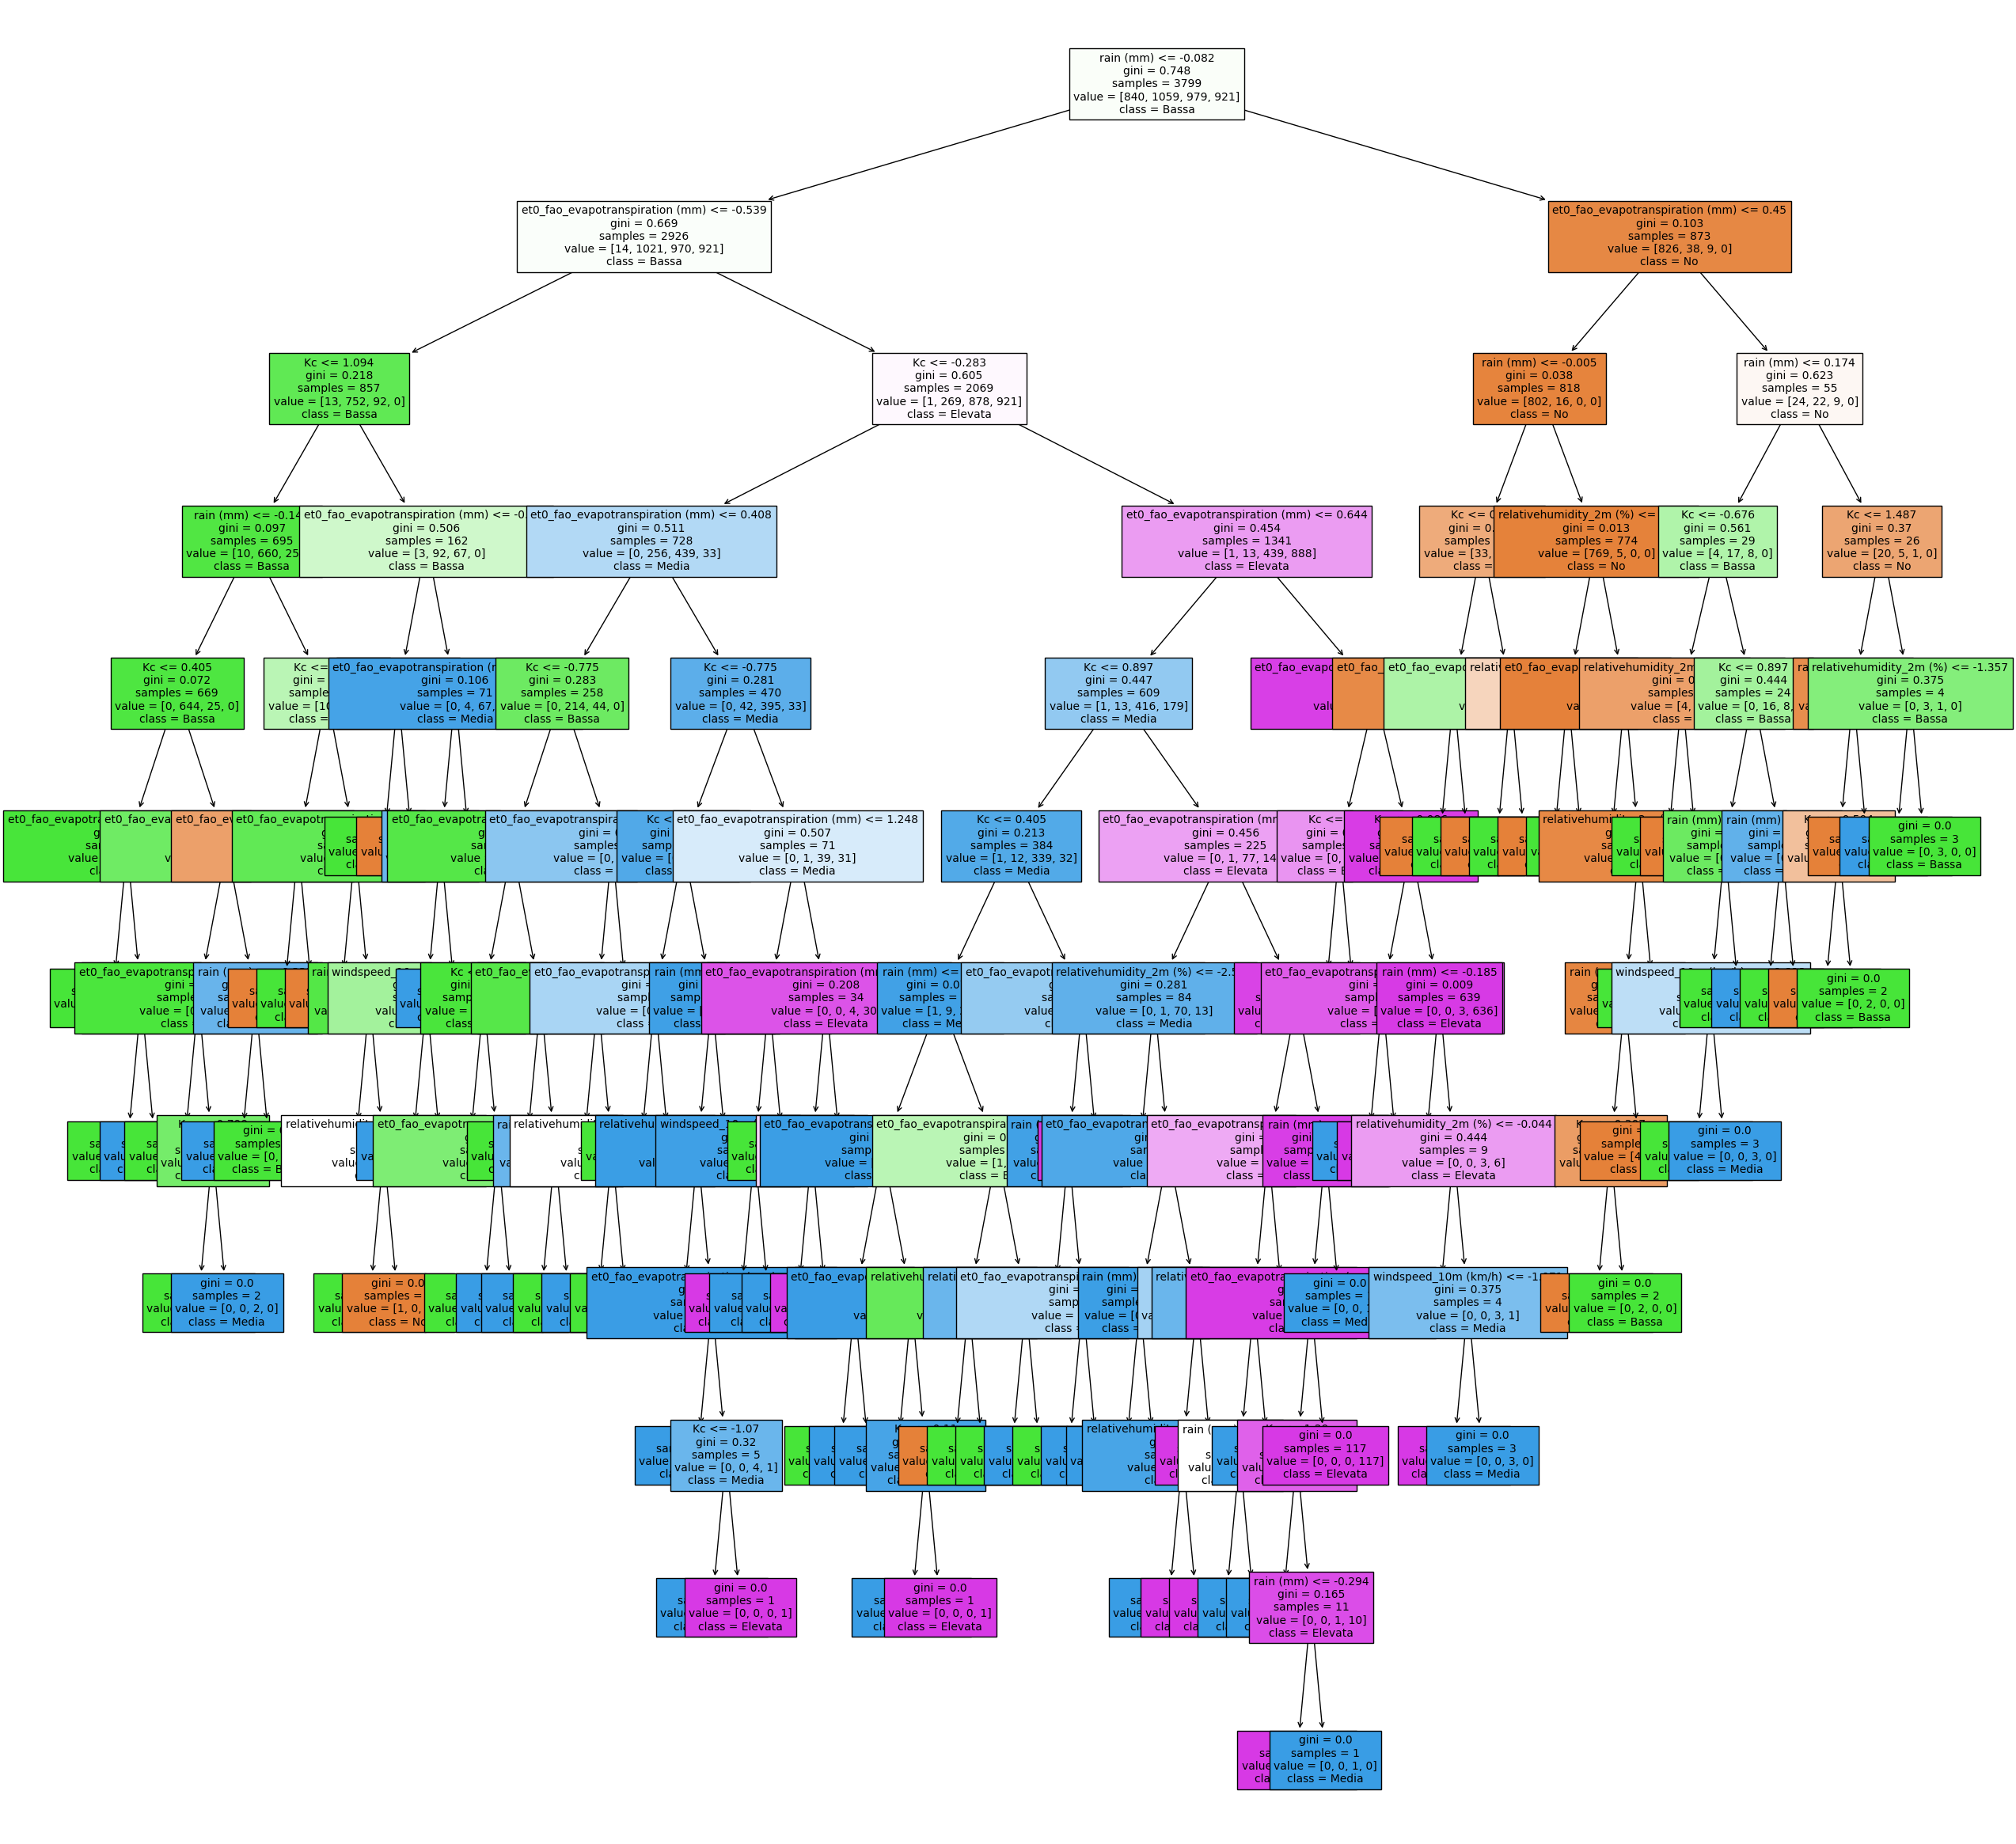

In [41]:
#plotta l'albero di decisione
plt.figure(figsize=(30,30))
tree.plot_tree(tree_clf, filled=True, fontsize=10, class_names=["No", "Bassa", "Media", "Elevata"], feature_names=irrigazione_X.columns)

In [42]:
bayes_clf = GaussianNB()
bayes_clf.fit(irr_X_train, irr_y_train)
pred_clf = bayes_clf.predict(irr_X_test)
print(classification_report(irr_y_test, pred_clf))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       222
           1       0.77      0.82      0.79       282
           2       0.72      0.69      0.70       232
           3       0.95      0.87      0.91       214

    accuracy                           0.83       950
   macro avg       0.84      0.84      0.84       950
weighted avg       0.84      0.83      0.83       950



In [43]:
forest_clf = RandomForestClassifier()
forest_clf.fit(irr_X_train, irr_y_train)
pred_clf = forest_clf.predict(irr_X_test)
print(classification_report(irr_y_test, pred_clf))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       222
           1       0.97      0.95      0.96       282
           2       0.95      0.94      0.95       232
           3       0.96      0.99      0.97       214

    accuracy                           0.97       950
   macro avg       0.97      0.97      0.97       950
weighted avg       0.97      0.97      0.97       950

